Importing all required libraries

In [77]:
import pandas as pd
import numpy as np
import pickle
import os 
import string
import re
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC  # For SVM classification
from sklearn.neural_network import MLPClassifier
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\h.ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

Loading Dataset

In [79]:
dataset = pd.read_csv("C:\data\RomanUrduDataset_WIP.csv", usecols = [0,1], names = ['Sentence','Catagories'], encoding='ISO-8859-1')

In [80]:
dataset = dataset.iloc[1:]

In [81]:
dataset = pd.DataFrame(dataset)

In [82]:
dataset['Catagories'].value_counts()

Catagories
religious offensive    200
political offensive    200
Neutral                200
Name: count, dtype: int64

In [83]:
dataset.duplicated().sum()

0

Data Pre-processing (Removing Punctuation, digits, special characters, white spaces, checking duplicates, converting to lower case)

In [84]:
def data_preprocessing(sentence):
    # Convert each sentence to lowercase
    sentence = sentence.str.lower()
     # Remove non-ASCII characters
    sentence = sentence.str.encode('ascii', 'ignore').str.decode('ascii')
    # Remove dots, punctuations, digits, and special characters
    sentence = sentence.str.replace(r'[^\w\s]', '')
    # Remove emoticons like :) :D :p :o
    sentence = sentence.str.replace(r'[:;][\)\(dpo*]', '')
    sentence = sentence.str.replace(r'([^\w\s]|_)+(?=\s|$)', '')
    sentence = sentence.apply(lambda x: ' '.join([re.sub(r'^\W.*', '', word) for word in x.split()]))
    sentence = sentence.apply(lambda x: ' '.join([re.sub(r'^\W+|\W+$', '', word) for word in x.split()]))
    # sentence = sentence.apply(lambda x: ' '.join([re.sub(r'^[^\w\s]+|[^\w\s]+$', '', word) for word in x.split()]))
    sentence = sentence.apply(lambda x: ' '.join([re.sub(r'([^\w\s]|_)+(?=\s|$)', '', word) for word in x.split()]))

    # Remove specific special characters like question marks
    sentence = sentence.str.replace(r'\?+', '')
    # Remove big words with length more than 10 characters
    sentence = sentence.apply(lambda x: ' '.join([word for word in x.split() if len(word) <= 10]))
    # Remove duplicate words in each sentence
    sentence = sentence.apply(lambda x: ' '.join(sorted(set(x.split()), key=x.split().index)))
    return sentence

In [85]:
# def data_preprocessing(ru_text):
#     ru_text = ru_text.astype(str).str.lower()
#     ru_text = ru_text.astype(str).str.replace('[{}]'.format(string.punctuation), '')
#     ru_text = ru_text.astype(str).str.replace("[^a-zA-Z#]",' ')
#     ru_text = ru_text.apply(lambda x: ' '.join([word for word in str(x).split() if not word.isdigit()]))
#     ru_text = ru_text.astype(str).str.strip()
#     return ru_text

In [86]:
dataset.replace('', np.nan, inplace = True)
dataset.dropna(inplace=True)
dataset['Sentence'] = data_preprocessing(dataset['Sentence'])

In [87]:
dataset

,Sentence,Catagories
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive
2,qadyani ka jo yaar hai ghaddar,religious offensive
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive
5,sary shia jahil hain in ky belief ki tarha,religious offensive
...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral
598,g m asaa kuch nh khti,Neutral
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral


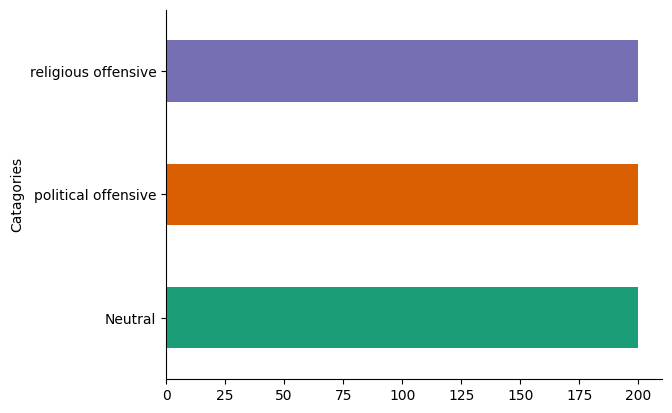

In [88]:
from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('Catagories').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [89]:
#sent = dataset["Sentence"]

In [90]:
dataset['lematized_sent'] = dataset.apply(lambda row: nltk.word_tokenize(row['Sentence']), axis=1)

Data Lematization

In [91]:
dataset

,Sentence,Catagories,lematized_sent
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive,"[aj, ek, shia, se, mila, mene, us, pocha, k, t..."
2,qadyani ka jo yaar hai ghaddar,religious offensive,"[qadyani, ka, jo, yaar, hai, ghaddar]"
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive,"[aby, jaa, khatmal, tum, sare, mutah, ki, paid..."
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive,"[mirza, qadyani, aur, is, ki, zaryat, ke, kafi..."
5,sary shia jahil hain in ky belief ki tarha,religious offensive,"[sary, shia, jahil, hain, in, ky, belief, ki, ..."
...,...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral,"[bhai, ye, kia, sun, raha, hun, is, ka, matlb,..."
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral,"[bhai, dunya, gol, ha, kisi, na, tariqe, se, y..."
598,g m asaa kuch nh khti,Neutral,"[g, m, asaa, kuch, nh, khti]"
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral,"[g, apne, friday, ko, e, ye, alfaz, milahaza, ..."


In [92]:
with open ("C:/data/ru_words.json") as f:
    ru_words = json.load(f)

In [93]:
def Lema(variations,token_sent):
  sents = token_sent.copy()
  lematized = []
  replacements = variations.keys()
  for i,tokens in enumerate(sents):
    for j,token in enumerate(tokens):
      if token in replacements:
        #print(f"Original  {token} with {variations[token]} on index {i}")
        tokens[j] = variations[token]
    #print(tokens)
    lematized.append(tokens)
  return lematized

In [94]:
token_sent = Lema(ru_words["ru_words"],dataset["lematized_sent"])

In [95]:
dataset['tokenized_sent'] = dataset.apply(lambda row: nltk.word_tokenize(row['Sentence']), axis=1)

In [96]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [97]:
dataset

,Sentence,Catagories,lematized_sent,tokenized_sent
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive,"[aj, ek, shia, se, mila, mene, us, pocha, k, t...","[aj, ek, shia, se, mila, mene, us, pocha, k, t..."
2,qadyani ka jo yaar hai ghaddar,religious offensive,"[qadyani, ka, jo, yaar, hai, ghaddar]","[qadyani, ka, jo, yaar, hai, ghaddar]"
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive,"[aby, jaa, khatmal, tum, sare, mutah, ki, paid...","[aby, jaa, khatmal, tum, sare, mutah, ki, paid..."
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive,"[mirza, qadyani, aur, is, ki, zaryat, ke, kafi...","[mirza, qadyani, aur, is, ki, zaryat, ke, kafi..."
5,sary shia jahil hain in ky belief ki tarha,religious offensive,"[sare, shia, jahil, hain, in, ky, belief, ki, ...","[sary, shia, jahil, hain, in, ky, belief, ki, ..."
...,...,...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral,"[bhai, ye, kia, sun, raha, hun, is, ka, matlb,...","[bhai, ye, kia, sun, raha, hun, is, ka, matlb,..."
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral,"[bhai, dunya, gol, ha, kisi, na, tariqe, se, y...","[bhai, dunya, gol, ha, kisi, na, tariqe, se, y..."
598,g m asaa kuch nh khti,Neutral,"[g, m, asaa, kuch, nahi, khti]","[g, m, asaa, kuch, nh, khti]"
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral,"[g, apne, friday, ko, e, ye, alfaz, milahaza, ...","[g, apne, friday, ko, e, ye, alfaz, milahaza, ..."


In [98]:
dataset['lematized_sent'] = dataset['lematized_sent'].str.join(' ')

In [100]:
dataset

,Sentence,Catagories,lematized_sent,tokenized_sent
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive,aj ek shia se mila mene us pocha k tum log zul...,"[aj, ek, shia, se, mila, mene, us, pocha, k, t..."
2,qadyani ka jo yaar hai ghaddar,religious offensive,qadyani ka jo yaar hai ghaddar,"[qadyani, ka, jo, yaar, hai, ghaddar]"
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive,aby jaa khatmal tum sare mutah ki paidawar ho,"[aby, jaa, khatmal, tum, sare, mutah, ki, paid..."
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive,mirza qadyani aur is ki zaryat ke kafir honay ...,"[mirza, qadyani, aur, is, ki, zaryat, ke, kafi..."
5,sary shia jahil hain in ky belief ki tarha,religious offensive,sare shia jahil hain in ky belief ki tarha,"[sary, shia, jahil, hain, in, ky, belief, ki, ..."
...,...,...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral,bhai ye kia sun raha hun is ka matlb me bilkul...,"[bhai, ye, kia, sun, raha, hun, is, ka, matlb,..."
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral,bhai dunya gol ha kisi na tariqe se ye bat sam...,"[bhai, dunya, gol, ha, kisi, na, tariqe, se, y..."
598,g m asaa kuch nh khti,Neutral,g m asaa kuch nahi khti,"[g, m, asaa, kuch, nh, khti]"
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral,g apne friday ko e ye alfaz milahaza fermae thy,"[g, apne, friday, ko, e, ye, alfaz, milahaza, ..."


Saving Dataset for Target Group Identification (task 02)

In [101]:
copy_data = dataset[['lematized_sent','Catagories']]
copy_data.to_csv(r'C:\results\task_02_data.csv', index=False)

In [26]:
# read_back_data = pd.read_csv(('/content/drive/MyDrive/Thesis_Data/Group_identification_data.csv'),index_col=0)
# read_back_data
# read_back_data = copy_data.copy()
# read_back_data = read_back_data.set_index(read_back_data.columns[0])
# read_back_data


Removing stopwords

In [27]:
dataset['lematized_sent'] = dataset.apply(lambda row: nltk.word_tokenize(row['lematized_sent']), axis=1)

In [28]:
dataset

,Sentence,Catagories,lematized_sent,tokenized_sent
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive,"[aj, ek, shia, se, mila, mene, us, pocha, k, t...","[aj, ek, shia, se, mila, mene, us, pocha, k, t..."
2,qadyani ka jo yaar hai ghaddar,religious offensive,"[qadyani, ka, jo, yaar, hai, ghaddar]","[qadyani, ka, jo, yaar, hai, ghaddar]"
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive,"[aby, jaa, khatmal, tum, sare, mutah, ki, paid...","[aby, jaa, khatmal, tum, sare, mutah, ki, paid..."
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive,"[mirza, qadyani, aur, is, ki, zaryat, ke, kafi...","[mirza, qadyani, aur, is, ki, zaryat, ke, kafi..."
5,sary shia jahil hain in ky belief ki tarha,religious offensive,"[sare, shia, jahil, hain, in, ky, belief, ki, ...","[sary, shia, jahil, hain, in, ky, belief, ki, ..."
...,...,...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral,"[bhai, ye, kia, sun, raha, hun, is, ka, matlb,...","[bhai, ye, kia, sun, raha, hun, is, ka, matlb,..."
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral,"[bhai, dunya, gol, ha, kisi, na, tariqe, se, y...","[bhai, dunya, gol, ha, kisi, na, tariqe, se, y..."
598,g m asaa kuch nh khti,Neutral,"[g, m, asaa, kuch, nahi, khti]","[g, m, asaa, kuch, nh, khti]"
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral,"[g, apne, friday, ko, e, ye, alfaz, milahaza, ...","[g, apne, friday, ko, e, ye, alfaz, milahaza, ..."


In [29]:
ru_stopwords =  ['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh ', 'bhi',
                 'aur', 'wo', 'yeh', 'rha', 'hota', 'ho', 'ga', 'ka', 'le', 'lye ', 'kr', 'kar',
                 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch', 'ab', 'thy', 'thay', 'houn',
                 'hain', 'han', 'to', 'is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala', 'waisay',
                 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha',
                 'nai', 'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa',
                 'aese', 'de', 'wohi', 'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova',
                 'yehi', 'jana', 'jye', 'chal', 'mil', 'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou',
                 'hn', 'rahe','karo','kro','kia','don','kha', 'aap','aby','agya','ap','app','aray','ary','ata','atay','ati','bd',
				         'bna','da','di','ek','esa','ge','ha','hmy','hon','hoti','hoty','hue','hue','huy','iss','jay','jaye','je','ji',
                 'karta','karte','karty','ky','liya','mn','mlti']

In [30]:
def stopwords_removal(ru_text):
  ru_text = ru_text.apply(lambda x: ' '.join([word for word in str(x).split() if not word in ru_stopwords]))
  return ru_text

In [31]:
dataset['lematized_sent'] = stopwords_removal(dataset['lematized_sent'].str.join(' '))

In [32]:
dataset


,Sentence,Catagories,lematized_sent,tokenized_sent
1,aj ek shia se mila mene us pocha k tum log zul...,religious offensive,aj shia mila mene pocha k tum log zuljana tatt...,"[aj, ek, shia, se, mila, mene, us, pocha, k, t..."
2,qadyani ka jo yaar hai ghaddar,religious offensive,qadyani yaar ghaddar,"[qadyani, ka, jo, yaar, hai, ghaddar]"
3,aby jaa khatmal tum sare mutah ki paidawar ho,religious offensive,jaa khatmal tum sare mutah paidawar,"[aby, jaa, khatmal, tum, sare, mutah, ki, paid..."
4,mirza qadyani aur is ki zaryat ke kafir honay ...,religious offensive,mirza qadyani zaryat ke kafir honay mein shak ...,"[mirza, qadyani, aur, is, ki, zaryat, ke, kafi..."
5,sary shia jahil hain in ky belief ki tarha,religious offensive,sare shia jahil in belief tarha,"[sary, shia, jahil, hain, in, ky, belief, ki, ..."
...,...,...,...,...
596,bhai ye kia sun raha hun is ka matlb me bilkul...,Neutral,bhai ye sun matlb me bilkul thek kehta,"[bhai, ye, kia, sun, raha, hun, is, ka, matlb,..."
597,bhai dunya gol ha kisi na tariqe se ye bat sam...,Neutral,bhai dunya gol kisi tariqe ye bat samne ani,"[bhai, dunya, gol, ha, kisi, na, tariqe, se, y..."
598,g m asaa kuch nh khti,Neutral,g m asaa nahi khti,"[g, m, asaa, kuch, nh, khti]"
599,g apne friday ko e ye alfaz milahaza fermae thy,Neutral,g apne friday e ye alfaz milahaza fermae,"[g, apne, friday, ko, e, ye, alfaz, milahaza, ..."


In [33]:
temp_data = dataset[['lematized_sent','Catagories']]

Spliting dataset traning 80% testing 20%

In [34]:
labelencoder = LabelEncoder()

X = temp_data['lematized_sent']
y = labelencoder.fit_transform(temp_data['Catagories'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
categories = list(set([categories for _, categories in enumerate(zip(temp_data['Catagories'], y.tolist()))]))
# categories = dict(categories)
categories = dict([(index, category) for category, index in categories])
categories

{0: 'Neutral', 2: 'religious offensive', 1: 'political offensive'}

Initialze N-gram range

In [36]:
vectorizer_uni = TfidfVectorizer()

vectorizer_uni.fit(X_train)

X_train_uni, X_test_uni = vectorizer_uni.transform(X_train), vectorizer_uni.transform(X_test)

print(type(vectorizer_uni))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


Testing Feature selection (Mutual Info & Chi2)

In [39]:
X_test_uni.shape, X_test.shape, y_test.shape

((120, 1619), (120,), (120,))

In [40]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')

def select_features(selection_method, k, X_train, y_train, X_test):
    """Applies feature selection and returns the selector along with transformed training and testing data."""
    selector = SelectKBest(selection_method, k=k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    return selector, X_train_transformed, X_test_transformed

# Define number of features for different selections
feature_numbers = [400, 800, 1200]

# Initialize a dictionary to store training and testing datasets
train_set = {}


# Apply feature selection for Chi-square
for k in feature_numbers:
    selector_chi, X_train_chi, X_test_chi = select_features(chi2, k, X_train_uni, y_train, X_test_uni)
    train_set[f"chi2_{k}"] = {
        "selector": selector_chi,
        "train": X_train_chi,
        "test": X_test_chi
    }

# Apply feature selection for Mutual Information
for k in feature_numbers:
    selector_mi, X_train_mi, X_test_mi = select_features(mutual_info_classif, k, X_train_uni, y_train, X_test_uni)
    train_set[f"mi_{k}"] = {
        "selector": selector_mi,
        "train": X_train_mi,
        "test": X_test_mi
    }

# Include unfiltered features as well
# Assuming there is a basic selector or process for 'uni' that you might want to keep track of (even if it's just identity)
train_set["uni"] = {
    "selector": vectorizer_uni,  # or an identity/select-all selector if applicable
    "train": X_train_uni,
    "test": X_test_uni
}

### Saving the selctors###
base_path = "C:\\Results\\Selectors"
# Ensure the directory exists; if not, create it
if not os.path.exists(base_path):
    os.makedirs(base_path)
for key, value in train_set.items():
    if value["selector"] is not None:
        # Construct the full file path
        file_path = os.path.join(base_path, f'selector_{key}.pkl')
        
        # Save the selector to the file
        with open(file_path, 'wb') as f:
            pickle.dump(value["selector"], f)

In [41]:
for i, train_set_key in enumerate(train_set):
         x_train=train_set.get(train_set_key)["train"]
         print(train_set_key)
         print(x_train)


chi2_400
  (0, 388)	0.3431510931988059
  (0, 307)	0.345788434434944
  (0, 265)	0.5182577064957191
  (0, 198)	0.49056631238126797
  (0, 190)	0.503419634760044
  (1, 328)	0.3892813329205754
  (1, 207)	0.2283544531051882
  (1, 197)	0.3264538688523205
  (2, 388)	0.24143344129228228
  (2, 377)	0.34515149544243506
  (2, 305)	0.33717473034061024
  (2, 227)	0.3920943527860786
  (2, 195)	0.41157739890698797
  (2, 102)	0.3920943527860786
  (3, 304)	0.6439696849245412
  (3, 269)	0.7650510080368413
  (4, 257)	0.25019636316941485
  (4, 26)	0.3059275437717956
  (4, 23)	0.34531249337969183
  (5, 368)	0.43286842010469856
  (5, 220)	0.4805704809666063
  (5, 84)	0.7626774834093286
  (6, 367)	0.6213933333379952
  (6, 211)	0.6213933333379952
  (6, 31)	0.4772218043700333
  :	:
  (470, 341)	0.29843917921162844
  (470, 268)	0.30625858075643553
  (470, 262)	0.17142259141095437
  (470, 181)	0.32596189901822253
  (471, 333)	0.2484417152719478
  (472, 300)	0.5978718910411236
  (472, 138)	0.5978718910411236
  (47

In [42]:
feature_names = vectorizer_uni.get_feature_names_out()
num_features = len(feature_names)

print(f"Number of UniGram features after TF-IDF transformation: {num_features}")



Number of UniGram features after TF-IDF transformation: 1619


Implementing Machine Learning Classifiers: Random Forest, Logistic Regression, SVM, Decision Tree, Naive Bayes, MLP, SGD

In [43]:
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def parse_classification_report(report, best_params):
    flat_report = flatten_dict(report)
    flat_report['best_params'] = best_params  # Add 'best_params' information to the flattened report
    df = pd.DataFrame.from_dict(flat_report, orient='index').transpose()
    return df

In [44]:
classifier_properties = {
    'random_forest': {'classifier': RandomForestClassifier(), 'param_grid_value': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2']}},
    'logistic_regression': {'classifier': LogisticRegression(), 'param_grid_value': {"C": np.logspace(-3, 3, 7), "penalty": ["l2"],"multi_class": ["ovr", "multinomial"],}},
    'svm_classifier': {
        'classifier': SVC(),
        'param_grid_value': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernel functions
            'decision_function_shape': ['ovr', 'ovo'],  # Decision function shape
        }
    },
    'decision_tree': {'classifier': DecisionTreeClassifier(),
        'param_grid_value': {
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['auto', 'sqrt', 'log2']
    }
},
    'nb_classifier': {'classifier': MultinomialNB(), 'param_grid_value': {'alpha': [0.1, 0.5, 1.0, 2.0]}},
    'mlp_classifier': {'classifier': MLPClassifier(), 'param_grid_value': {'hidden_layer_sizes': [(50, 25), (100,)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]}},
    'SGD_classifier': {'classifier': SGDClassifier(), 'param_grid_value': {'alpha': [0.0001, 0.001, 0.01, 0.1], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'penalty': ['l2', 'l1', 'elasticnet']}}
}


In [45]:
def classify(feature_name, classifier, x_train, y_train, x_test, y_test):
  grid_search = GridSearchCV(classifier["classifier"], classifier["param_grid_value"], cv=7, n_jobs=-1)
  grid_search.fit(x_train, y_train)
  best_params = grid_search.best_params_
  best_model = classifier["classifier"].__class__(**best_params)
  best_model.fit(x_train, y_train)

  # Saving the classifeer...
  folder_path = "C:/Results"
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)
  pickle_file_path = os.path.join(folder_path, f"{classifier['classifier'].__class__.__name__}_{feature_name}.pkl")
  with open(pickle_file_path, 'wb') as file:
    pickle.dump(best_model, file)

  # Evaluate the model on the test dataset
  y_pred = best_model.predict(x_test)
  report = classification_report(y_test, y_pred, output_dict=True)
  #print(classification_report(y_test, y_pred))
  print(report)
  accuracy = best_model.score(x_test, y_test)
  print(f"Test Set Accuracy: {accuracy:.2f}")
  print(best_params)

 # Save classification report to CSV file
  reports.append({'classifier': classifier['classifier'].__class__.__name__, 'report': report, 'params': best_params})
  dfs = []
  for report in reports:
     classifier_name = report['classifier']
     classifier_report = parse_classification_report(report['report'],report['params'])
     classifier_report['classifier'] = classifier_name
     dfs.append(classifier_report)
  combined_report = pd.concat(dfs)
  file_path = "C:/Results/combined_classification_report_" + feature_name + ".csv"
  combined_report.to_csv(file_path, index=False)
  print(f"Combined classification report saved as 'combined_classification_report_{feature_name}.csv'")


  print("\n")


  # conf_matrix = confusion_matrix(y_test, y_pred)
  # print("Confusion Matrix:")
  # print(conf_matrix)
  # print("\n")

  # plt.figure(figsize=(5,5))
  # sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
  # plt.ylabel('Actual label')
  # plt.xlabel('Predicted label')
  # plt.title('Confusion Matrix', size = 15)
  # plt.show()
  csv_file_path = os.path.join(folder_path, f"{classifier['classifier']}_{feature_name}_MissClassified.csv")
  #print("Missclassified sentences and their labels")
  misclassified_indice_lables = [(i, true_label, pred_label) for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)) if true_label != pred_label]

  missclassified_sentences = [(X_test.iloc[index], categories[true_label], categories[pred_label])  for (index, true_label, pred_label) in misclassified_indice_lables]
  pd.DataFrame(missclassified_sentences, columns=["Sentence", "True Value",  "Predicted Value"]).to_csv(csv_file_path, index=False)
  print("\n")


Classification with  CHi2 and Mutual Info Feature Selection

In [46]:
for a in train_set:
  print(a)

chi2_400
chi2_800
chi2_1200
mi_400
mi_800
mi_1200
uni


In [47]:
for i, train_set_key in enumerate(train_set):
  reports = []
  for classifier in classifier_properties:
    print(f"Classification for model: {classifier}")
    classify(feature_name=train_set_key,
             classifier=classifier_properties[classifier],
             x_train=train_set.get(train_set_key)["train"],
             y_train=y_train,
             x_test=train_set.get(train_set_key)["test"],
             y_test=y_test)


Classification for model: random_forest
{'0': {'precision': 0.6949152542372882, 'recall': 1.0, 'f1-score': 0.82, 'support': 41.0}, '1': {'precision': 0.96, 'recall': 0.6666666666666666, 'f1-score': 0.7868852459016393, 'support': 36.0}, '2': {'precision': 1.0, 'recall': 0.8372093023255814, 'f1-score': 0.9113924050632911, 'support': 43.0}, 'accuracy': 0.8416666666666667, 'macro avg': {'precision': 0.8849717514124293, 'recall': 0.834625322997416, 'f1-score': 0.8394258836549767, 'support': 120.0}, 'weighted avg': {'precision': 0.8837627118644068, 'recall': 0.8416666666666667, 'f1-score': 0.842814518918171, 'support': 120.0}}
Test Set Accuracy: 0.84
{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Combined classification report saved as 'combined_classification_report_chi2_400.csv'




Classification for model: logistic_regression
{'0': {'precision': 0.8163265306122449, 'recall': 0.975609756097561, 'f1-score': 0.8888888888888888, 'support': 41.0}, '1': {'precision': 0.9375, 'r

Loading all classification report

In [48]:
report_chi2_400 = pd.read_csv("C:\Results\combined_classification_report_chi2_400.csv")
report_chi2_800 = pd.read_csv("C:\Results\combined_classification_report_chi2_800.csv")
report_chi2_1200 = pd.read_csv("C:\Results\combined_classification_report_chi2_1200.csv")

report_mi_400 = pd.read_csv("C:\Results\combined_classification_report_mi_400.csv")
report_mi_800 = pd.read_csv("C:\Results\combined_classification_report_mi_800.csv")
report_mi_1200 = pd.read_csv("C:\Results\combined_classification_report_mi_1200.csv")

report_uni = pd.read_csv("C:\Results\combined_classification_report_uni.csv")


In [49]:
def prepare_report(df, feature_selection_tag):
    df = df[['classifier', 'accuracy', 'macro avg_precision', 'macro avg_recall', 'macro avg_f1-score', 'best_params']]
    # Add a new column with a fixed value indicating the feature selection method
    df['Feature Selection'] = [feature_selection_tag] * len(df)
    return df


In [50]:
report_chi2_400 = prepare_report(report_chi2_400, 'chi2_400')
report_chi2_800 = prepare_report(report_chi2_800, 'chi2_800')
report_chi2_1200 = prepare_report(report_chi2_1200, 'chi2_1200')

report_mi_400 = prepare_report(report_mi_400, 'mi_400')
report_mi_800 = prepare_report(report_mi_800, 'mi_800')
report_mi_1200 = prepare_report(report_mi_1200, 'mi_1200')

report_uni = prepare_report(report_uni, 'All features')

In [51]:
df_report_chi2_400 = pd.DataFrame(report_chi2_400)
df_report_chi2_800 = pd.DataFrame(report_chi2_800)
df_report_chi2_1200 = pd.DataFrame(report_chi2_1200)

merge_df_chi2 = pd.concat([df_report_chi2_400,df_report_chi2_800,df_report_chi2_1200], axis=0)
merge_df_chi2.reset_index(drop=True, inplace=True)
columns_to_round = ['accuracy', 'macro avg_precision', 'macro avg_recall', 'macro avg_f1-score']
merge_df_chi2[columns_to_round] = merge_df_chi2[columns_to_round].apply(lambda x: round(x, 3))
merge_df_chi2.to_csv(r'C:\results\report_chi2.csv', index=False)
merge_df_chi2

,classifier,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,best_params,Feature Selection
0,RandomForestClassifier,0.842,0.885,0.835,0.839,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",chi2_400
1,LogisticRegression,0.883,0.892,0.882,0.883,"{'C': 100.0, 'multi_class': 'ovr', 'penalty': ...",chi2_400
2,SVC,0.883,0.895,0.882,0.883,"{'C': 1, 'decision_function_shape': 'ovr', 'ke...",chi2_400
3,DecisionTreeClassifier,0.792,0.814,0.788,0.792,"{'criterion': 'entropy', 'max_depth': None, 'm...",chi2_400
4,MultinomialNB,0.733,0.774,0.739,0.723,{'alpha': 0.1},chi2_400
5,MLPClassifier,0.842,0.849,0.841,0.842,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",chi2_400
6,SGDClassifier,0.883,0.895,0.882,0.883,"{'alpha': 0.001, 'loss': 'squared_hinge', 'pen...",chi2_400
7,RandomForestClassifier,0.858,0.889,0.853,0.857,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",chi2_800
8,LogisticRegression,0.917,0.920,0.917,0.917,"{'C': 100.0, 'multi_class': 'ovr', 'penalty': ...",chi2_800
9,SVC,0.858,0.865,0.857,0.858,"{'C': 10, 'decision_function_shape': 'ovr', 'k...",chi2_800


In [52]:
df_report_mi_400 = pd.DataFrame(report_mi_400)
df_report_mi_800 = pd.DataFrame(report_mi_800)
df_report_mi_1200 = pd.DataFrame(report_mi_1200)

merge_df_mi = pd.concat([df_report_mi_400,df_report_mi_800,df_report_mi_1200], axis=0)
merge_df_mi.reset_index(drop=True, inplace=True)
columns_to_round = ['accuracy', 'macro avg_precision', 'macro avg_recall', 'macro avg_f1-score']
merge_df_mi[columns_to_round] = merge_df_mi[columns_to_round].apply(lambda x: round(x, 3))
merge_df_mi.to_csv(r'C:\results\report_mi.csv', index=False)
merge_df_mi

,classifier,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,best_params,Feature Selection
0,RandomForestClassifier,0.825,0.852,0.824,0.827,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",mi_400
1,LogisticRegression,0.875,0.877,0.874,0.875,"{'C': 100.0, 'multi_class': 'ovr', 'penalty': ...",mi_400
2,SVC,0.858,0.865,0.856,0.858,"{'C': 1, 'decision_function_shape': 'ovr', 'ke...",mi_400
3,DecisionTreeClassifier,0.783,0.794,0.778,0.780,"{'criterion': 'gini', 'max_depth': None, 'max_...",mi_400
4,MultinomialNB,0.758,0.764,0.763,0.754,{'alpha': 2.0},mi_400
5,MLPClassifier,0.825,0.827,0.824,0.825,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_...",mi_400
6,SGDClassifier,0.867,0.875,0.866,0.867,"{'alpha': 0.01, 'loss': 'modified_huber', 'pen...",mi_400
7,RandomForestClassifier,0.817,0.847,0.815,0.818,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",mi_800
8,LogisticRegression,0.858,0.868,0.857,0.858,"{'C': 10.0, 'multi_class': 'ovr', 'penalty': '...",mi_800
9,SVC,0.867,0.872,0.864,0.866,"{'C': 1, 'decision_function_shape': 'ovr', 'ke...",mi_800


In [53]:
report_uni = pd.DataFrame(report_uni)
columns_to_round = ['accuracy', 'macro avg_precision', 'macro avg_recall', 'macro avg_f1-score']
report_uni[columns_to_round] = report_uni[columns_to_round].apply(lambda x: round(x, 3))
report_uni.to_csv(r'C:\results\report_uni.csv', index=False)
report_uni

,classifier,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,best_params,Feature Selection
0,RandomForestClassifier,0.858,0.878,0.857,0.859,"{'max_depth': 20, 'max_features': 'log2', 'n_e...",All features
1,LogisticRegression,0.892,0.896,0.892,0.892,"{'C': 10.0, 'multi_class': 'multinomial', 'pen...",All features
2,SVC,0.892,0.893,0.891,0.892,"{'C': 10, 'decision_function_shape': 'ovr', 'k...",All features
3,DecisionTreeClassifier,0.767,0.772,0.764,0.765,"{'criterion': 'gini', 'max_depth': None, 'max_...",All features
4,MultinomialNB,0.817,0.828,0.817,0.812,{'alpha': 0.5},All features
5,MLPClassifier,0.867,0.868,0.865,0.866,"{'activation': 'tanh', 'alpha': 0.01, 'hidden_...",All features
6,SGDClassifier,0.892,0.894,0.892,0.892,"{'alpha': 0.001, 'loss': 'hinge', 'penalty': '...",All features


Finding maximum and minuímum accuracies in Chi2 & Mutual Info feature selection

In [54]:
def get_accuracy_details(df, feature_name):
    # Finding index of max and min accuracies
    max_accuracy_index = df['accuracy'].idxmax()
    min_accuracy_index = df['accuracy'].idxmin()
    
    # Extracting details for maximum accuracy
    max_details = {
        'Classifier': df.loc[max_accuracy_index, 'classifier'],
        'Type': 'Highest',
        'Accuracy': df.loc[max_accuracy_index, 'accuracy'],
        'Macro Avg Precision': df.loc[max_accuracy_index, 'macro avg_precision'],
        'Macro Avg Recall': df.loc[max_accuracy_index, 'macro avg_recall'],
        'Feature Selection': df.loc[max_accuracy_index, 'Feature Selection']
    }
    
    # Extracting details for minimum accuracy
    min_details = {
        'Classifier': df.loc[min_accuracy_index, 'classifier'],
        'Type': 'Lowest',
        'Accuracy': df.loc[min_accuracy_index, 'accuracy'],
        'Macro Avg Precision': df.loc[min_accuracy_index, 'macro avg_precision'],
        'Macro Avg Recall': df.loc[min_accuracy_index, 'macro avg_recall'],
        'Feature Selection': df.loc[min_accuracy_index, 'Feature Selection']
    }
    
    # Creating DataFrame from details with specific column order
    results_df = pd.DataFrame([max_details, min_details], columns=[
        'Classifier', 'Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Feature Selection'
    ])
    return results_df

# Using the function and combining results
results_chi2 = get_accuracy_details(merge_df_chi2, 'Chi2')
results_mi = get_accuracy_details(merge_df_mi, 'Mutual Information')
results_uni = get_accuracy_details(report_uni, 'Unfiltered')

# Combining all results into a single DataFrame
final_results = pd.concat([results_chi2, results_mi, results_uni], ignore_index=True)
final_results

,Classifier,Accuracy,Macro Avg Precision,Macro Avg Recall,Feature Selection
0,SGDClassifier,0.925,0.927,0.925,chi2_800
1,MultinomialNB,0.733,0.774,0.739,chi2_400
2,LogisticRegression,0.875,0.877,0.874,mi_400
3,DecisionTreeClassifier,0.717,0.717,0.713,mi_1200
4,LogisticRegression,0.892,0.896,0.892,All features
5,DecisionTreeClassifier,0.767,0.772,0.764,All features


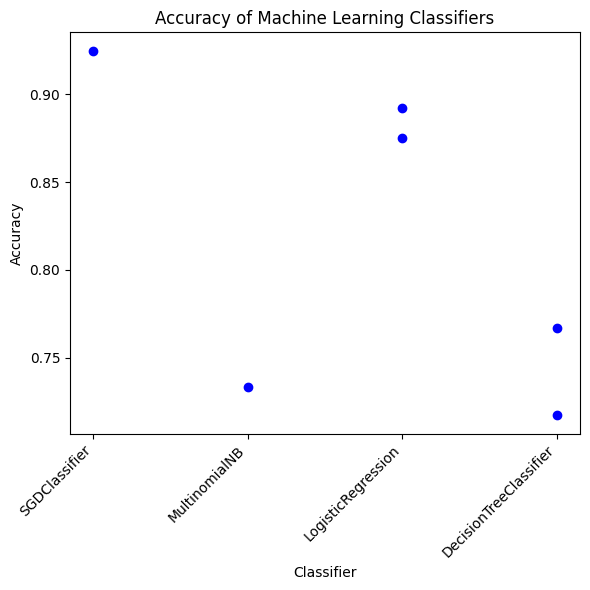

In [74]:
plt.figure(figsize=(6, 6))
plt.scatter(final_results['Classifier'], final_results['Accuracy'], color='blue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy of Machine Learning Classifiers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [68]:
def load_model(file_path):
    """Helper function to load a model from a specified file path."""
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Define model and selector file paths
logistic_regression_path = "C:/Results/LogisticRegression_chi2_800.pkl"
chi2_selector_path = "C:/Results/Selectors/selector_chi2_800.pkl"
decision_tree_path = "C:/Results/DecisionTreeClassifier_uni.pkl"
vectorizer_path = "C:/Results/Selectors/selector_uni.pkl"

# Load models and selectors using the helper function
logistic_regression = load_model(logistic_regression_path)
chi2_selector = load_model(chi2_selector_path)
decision_tree = load_model(decision_tree_path)
vectorizer = load_model(vectorizer_path)


<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [107]:
# Process new text data
new_text = ["tum jeson ko to ddob kar majana chaye"]
test_vector = vectorizer.transform(new_text)
new_data_transformed = chi2_selector.transform(test_vector)

# Make predictions using the Logistic Regression and Decision Tree models
prediction_lr = logistic_regression.predict(new_data_transformed)
prediction_dt = decision_tree.predict(test_vector)

# Define a function to print the decision tree prediction
def print_decision_tree_prediction(prediction):
    if prediction == 0:
        print("Predicted class with decision tree: 0 Neutral")
    elif prediction == 1:
        print("Predicted class with decision tree: 1 Political Offensive")
    else:
        print("Predicted class with decision tree:", prediction, "Religious Offensive")

# Define a function to print the logistic regression prediction
def print_logistic_regression_prediction(prediction):
    if prediction == 0:
        print("Predicted class with Logistic Regression: 0 Neutral")
    elif prediction == 1:
        print("Predicted class with Logistic Regression: 1 Political Offensive")
    else:
        print("Predicted class with Logistic Regression:", prediction, "Religious Offensive")

# Call the print functions to display predictions
print_decision_tree_prediction(prediction_dt)
print_logistic_regression_prediction(prediction_lr)

Predicted class with decision tree: 0 Neutral
Predicted class with Logistic Regression: [2] Religious Offensive
